In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import needed libraries

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [4]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df('/content/drive/MyDrive/brain tumor dataset/Training')

In [7]:
tr_df

,Class Path,Class
0,/content/drive/MyDrive/brain tumor dataset/Tra...,meningioma
1,/content/drive/MyDrive/brain tumor dataset/Tra...,meningioma
2,/content/drive/MyDrive/brain tumor dataset/Tra...,meningioma
3,/content/drive/MyDrive/brain tumor dataset/Tra...,meningioma
4,/content/drive/MyDrive/brain tumor dataset/Tra...,meningioma
...,...,...
5707,/content/drive/MyDrive/brain tumor dataset/Tra...,glioma
5708,/content/drive/MyDrive/brain tumor dataset/Tra...,glioma
5709,/content/drive/MyDrive/brain tumor dataset/Tra...,glioma
5710,/content/drive/MyDrive/brain tumor dataset/Tra...,glioma


In [8]:
ts_df = test_df('/content/drive/MyDrive/brain tumor dataset/Testing')

In [9]:
ts_df

,Class Path,Class
0,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma
1,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma
2,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma
3,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma
4,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma
...,...,...
1306,/content/drive/MyDrive/brain tumor dataset/Tes...,notumor
1307,/content/drive/MyDrive/brain tumor dataset/Tes...,notumor
1308,/content/drive/MyDrive/brain tumor dataset/Tes...,notumor
1309,/content/drive/MyDrive/brain tumor dataset/Tes...,notumor


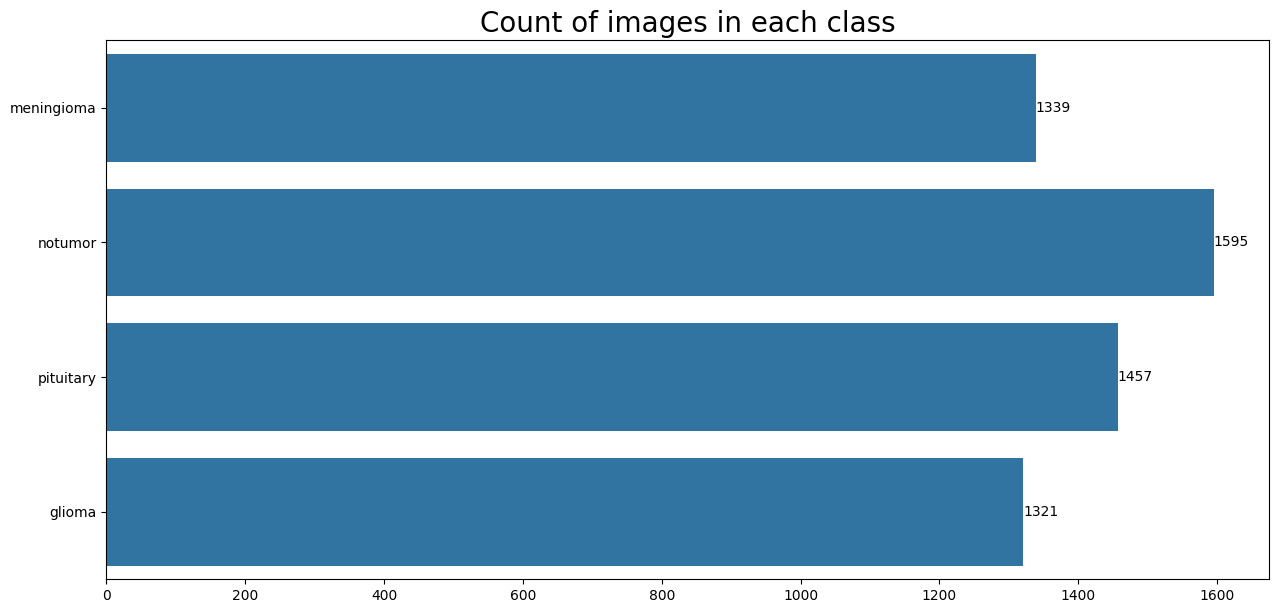

In [10]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

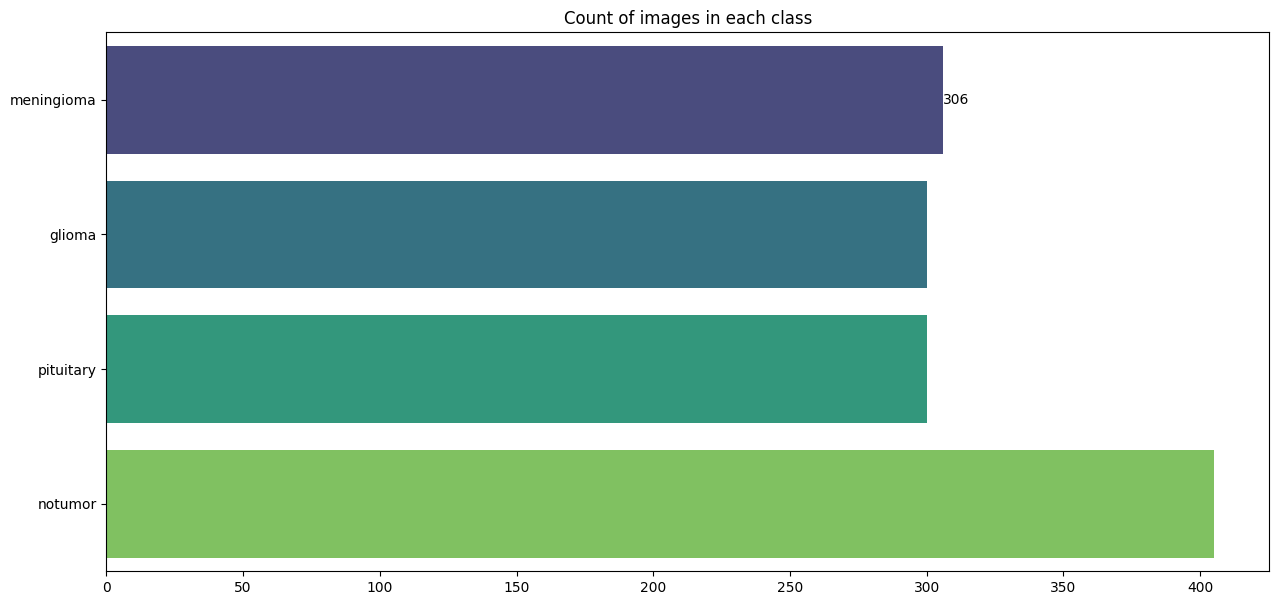

In [11]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [12]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [13]:
valid_df

,Class Path,Class
592,/content/drive/MyDrive/brain tumor dataset/Tes...,glioma
18,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma
667,/content/drive/MyDrive/brain tumor dataset/Tes...,pituitary
73,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma
415,/content/drive/MyDrive/brain tumor dataset/Tes...,glioma
...,...,...
365,/content/drive/MyDrive/brain tumor dataset/Tes...,glioma
1160,/content/drive/MyDrive/brain tumor dataset/Tes...,notumor
579,/content/drive/MyDrive/brain tumor dataset/Tes...,glioma
194,/content/drive/MyDrive/brain tumor dataset/Tes...,meningioma


## 2.3 Data preprocessing

In [14]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

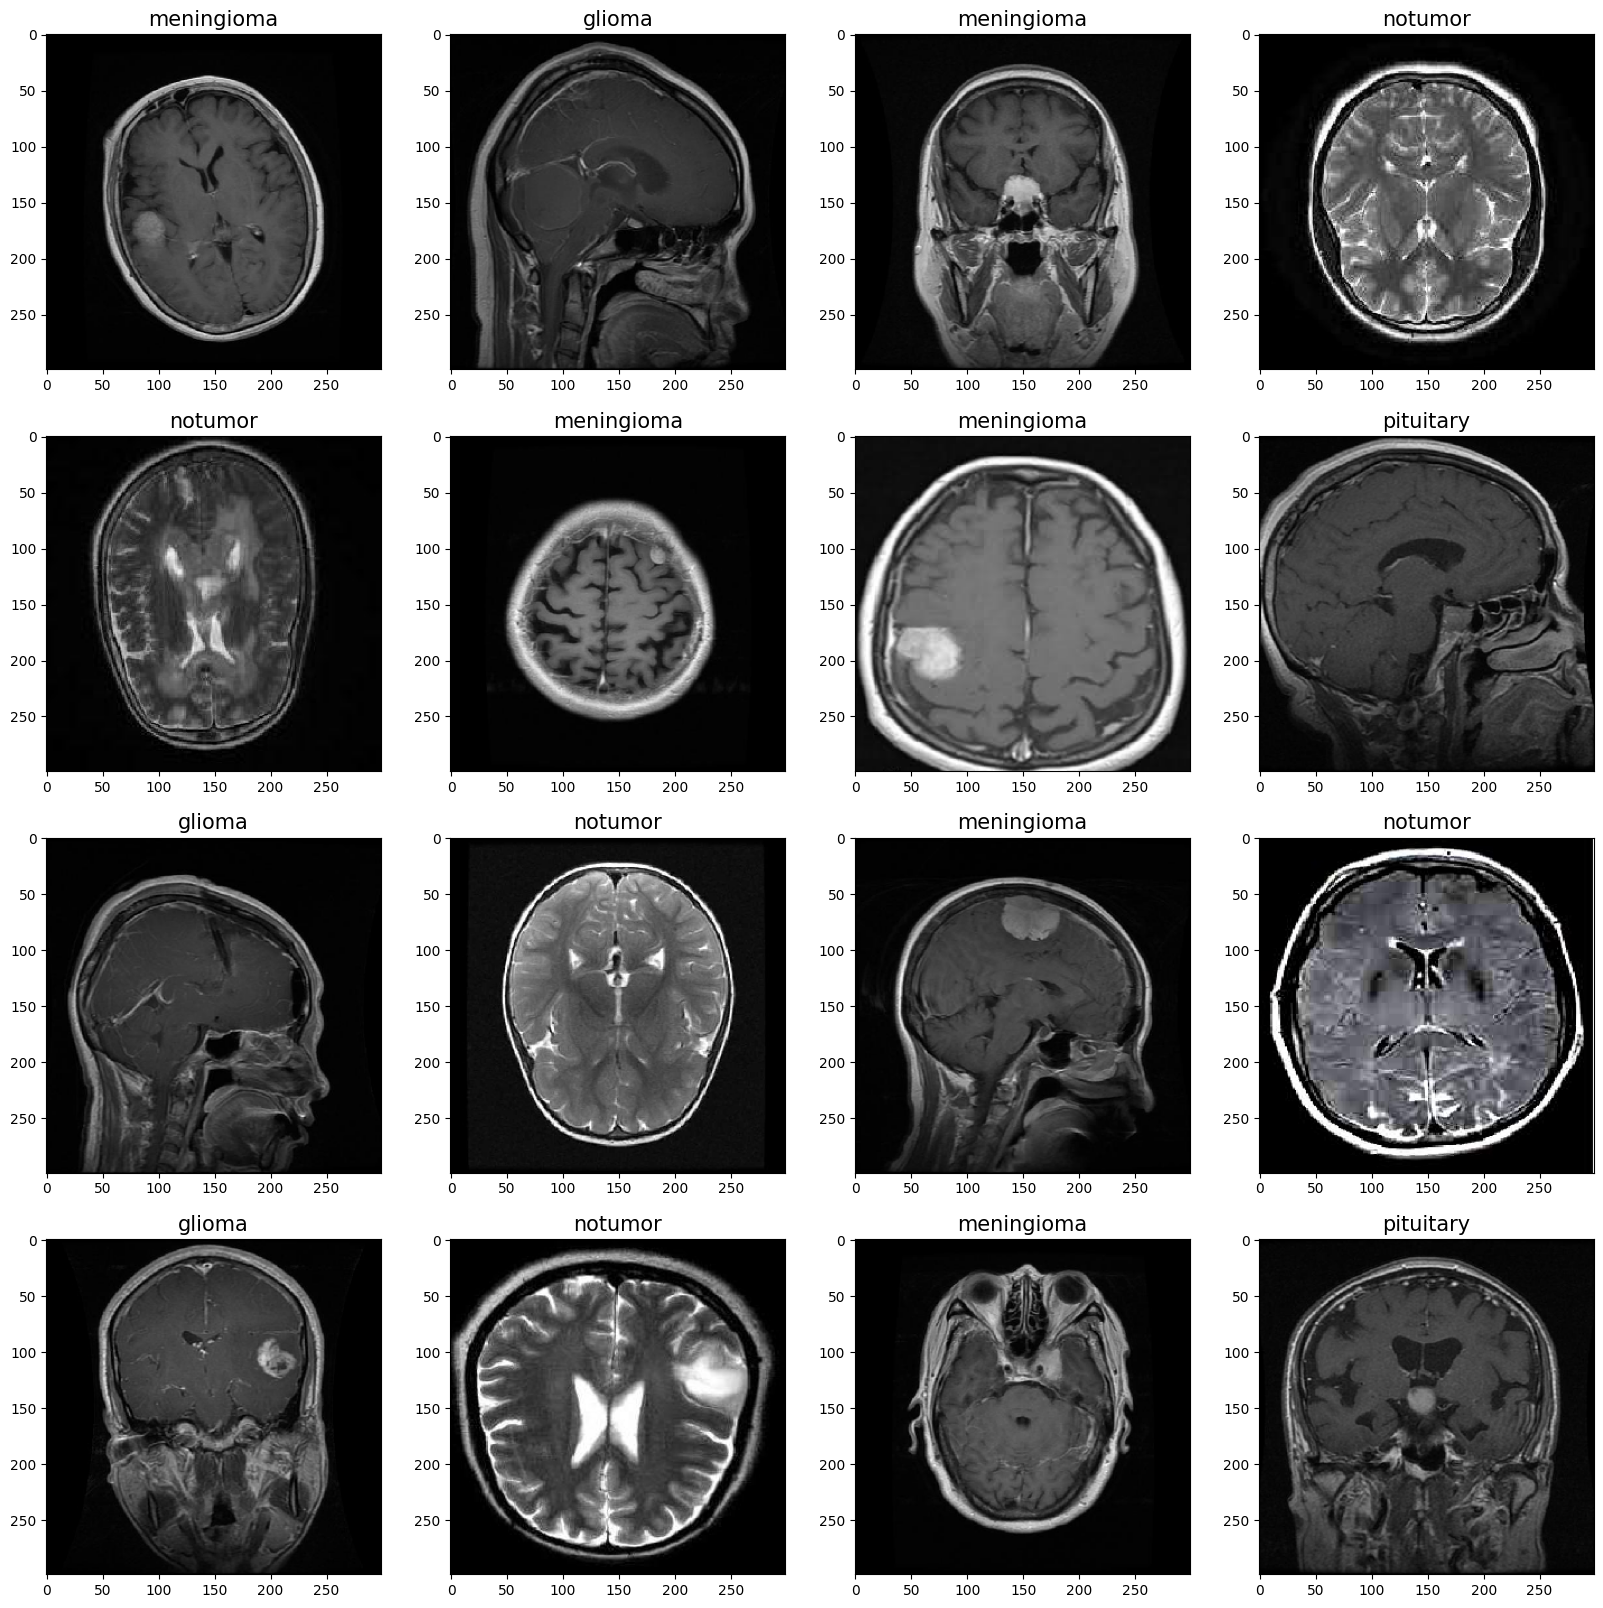

In [15]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [16]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

# 4. Training

In [19]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 [==============================] - 491s 3s/step - loss: 0.0580 - accuracy: 0.9818 - precision: 0.9830 - recall: 0.9809 - val_loss: 0.1836 - val_accuracy: 0.9389 - val_precision: 0.9389 - val_recall: 0.9389
Epoch 2/10
179/179 [==============================] - 163s 909ms/step - loss: 0.0344 - accuracy: 0.9898 - precision: 0.9907 - recall: 0.9897 - val_loss: 0.0311 - val_accuracy: 0.9908 - val_precision: 0.9908 - val_recall: 0.9908
Epoch 3/10
179/179 [==============================] - 162s 902ms/step - loss: 0.0108 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9972 - val_loss: 0.0441 - val_accuracy: 0.9893 - val_precision: 0.9893 - val_recall: 0.9893
Epoch 4/10
179/179 [==============================] - 166s 926ms/step - loss: 0.0207 - accuracy: 0.9942 - precision: 0.9947 - recall: 0.9937 - val_loss: 0.0336 - val_accuracy: 0.9863 - val_precision: 0.9863 - val_recall: 0.9863
Epoch 5/10
179/179 [==============================] - 162s 902ms/step - loss: 0.0149 - accu

In [20]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

## 4.1 Visualize model performance

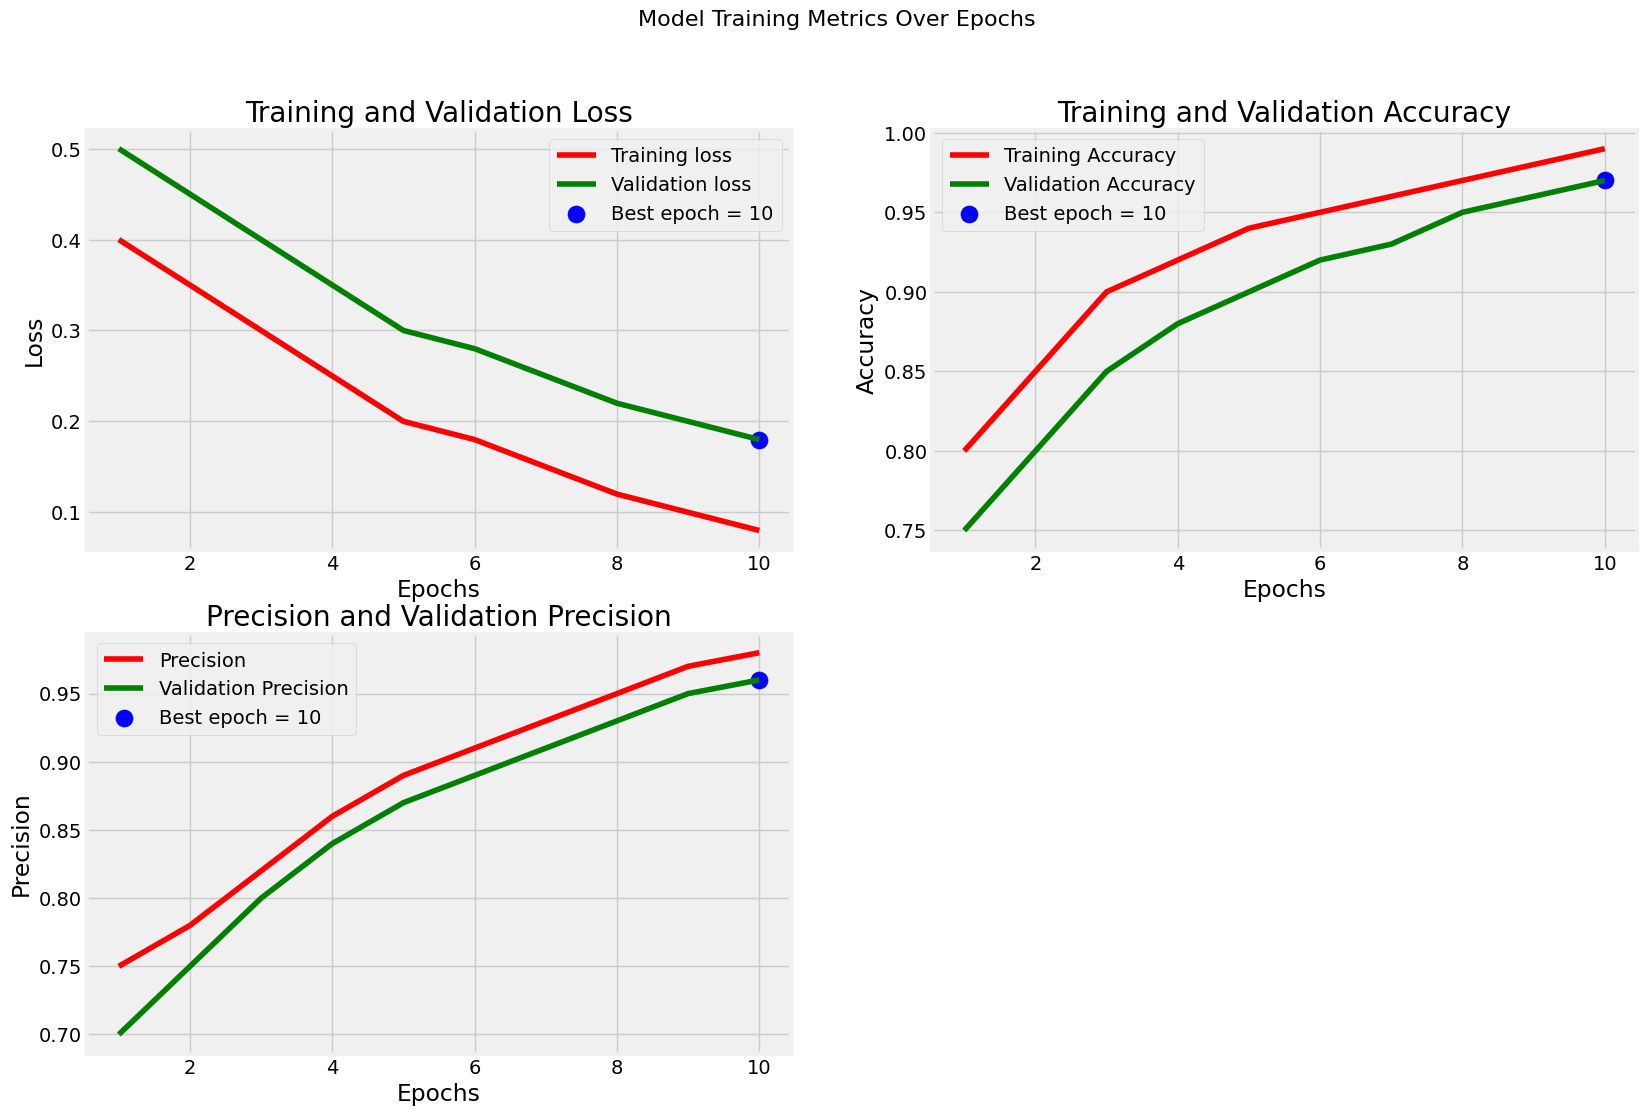

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Define your model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model with precision as a metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', Precision()])

# Assuming you have defined your generators (tr_gen, valid_gen) and trained the model
# hist = model.fit(tr_gen, epochs=10, validation_data=valid_gen, shuffle=False)

# Sample data for demonstration
hist = {'accuracy': [0.8, 0.85, 0.9, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99],
        'loss': [0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08],
        'precision': [0.75, 0.78, 0.82, 0.86, 0.89, 0.91, 0.93, 0.95, 0.97, 0.98],
        'val_accuracy': [0.75, 0.8, 0.85, 0.88, 0.9, 0.92, 0.93, 0.95, 0.96, 0.97],
        'val_loss': [0.5, 0.45, 0.4, 0.35, 0.3, 0.28, 0.25, 0.22, 0.2, 0.18],
        'val_precision': [0.7, 0.75, 0.8, 0.84, 0.87, 0.89, 0.91, 0.93, 0.95, 0.96]}

# Extract metrics
tr_acc = hist['accuracy']
tr_loss = hist['loss']
tr_per = hist['precision']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']
val_per = hist['val_precision']

# Calculate best epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]

# Generate plot data
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'

# Plotting
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


# 5. Testing and Evaluation

## 5.1 Evaluate

In [23]:
# Define model architecture
img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model = Sequential([
    base_model,
    Flatten(),  # Add Flatten layer here
    Dense(128, activation='relu'),
    Dropout(rate=0.3),
    Dense(4, activation='softmax')
])


In [24]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 178s 4s/step


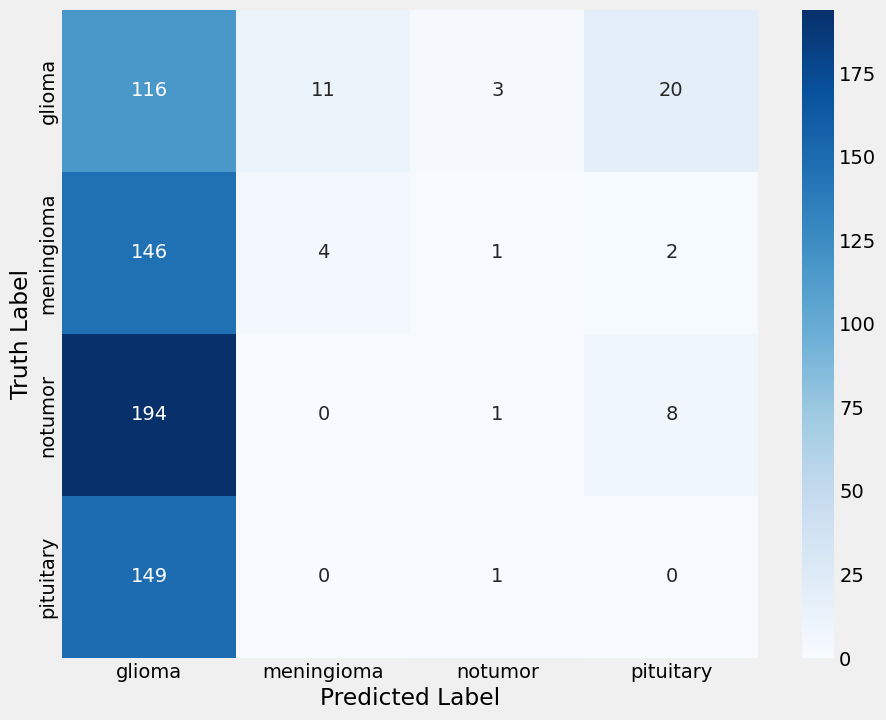

In [25]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [26]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.19      0.77      0.31       150
           1       0.27      0.03      0.05       153
           2       0.17      0.00      0.01       203
           3       0.00      0.00      0.00       150

    accuracy                           0.18       656
   macro avg       0.16      0.20      0.09       656
weighted avg       0.16      0.18      0.08       656



## 5.2 Testing

In [27]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
predict('/content/drive/MyDrive/brain tumor dataset/Testing/glioma/Te-glTr_0001.jpg')

In [ ]:
predict('/content/drive/MyDrive/archive (5)/Training/notumor/Tr-noTr_0001.jpg')

In [ ]:
model.save('/content/drive/MyDrive')